In [1]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

In [2]:
import json

with open('C:/Users/dubin/PycharmProjects/Clip/annotations_trainval2014/captions_train2014.json', 'r') as file:
    captions_train2014 = json.load(file)

text_pairs = []

for t in captions_train2014['annotations']:
    target = "[start] " + t["caption"] + " [end]"
    text_pairs.append((t["caption"], target))


In [3]:
for _ in range(5):
    print(random.choice(text_pairs))

('A rustic cabin kitchen constructed of various wood species.', '[start] A rustic cabin kitchen constructed of various wood species. [end]')
('Two baseball players give each other a high five at home plate.', '[start] Two baseball players give each other a high five at home plate. [end]')
('A white car near a stop sign and a big building', '[start] A white car near a stop sign and a big building [end]')
('a man is skateboarding in a bowl outside', '[start] a man is skateboarding in a bowl outside [end]')
('Sculptures sitting on a table in a room.', '[start] Sculptures sitting on a table in a room. [end]')


In [4]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

414113 total pairs
289881 training pairs
62116 validation pairs
62116 test pairs


In [5]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 32
batch_size = 64

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

train_texts = [pair[1] for pair in train_pairs]
vectorization.adapt(train_texts)

In [6]:
def format_dataset(caption, target):
    target = vectorization(target)
    return (
        {
            "encoder_inputs": caption,
            "decoder_inputs": target[:, :-1],
        },
        target[:, 1:],
    )


def make_dataset(pairs):
    caption, target = zip(*pairs)
    caption = list(caption)
    target = list(target)
    dataset = tf.data.Dataset.from_tensor_slices((caption, target))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [7]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(inputs["encoder_inputs"][0])
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(inputs["decoder_inputs"][0])
    print(f"targets.shape: {targets.shape}")
    print(targets[0])

inputs["encoder_inputs"].shape: (64,)
tf.Tensor(b'A woman poses next to microwaves while holding a plate.', shape=(), dtype=string)
inputs["decoder_inputs"].shape: (64, 32)
tf.Tensor(
[   3    2   23  707   21   13 2855   55   27    2   43    4    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(32,), dtype=int64)
targets.shape: (64, 32)
tf.Tensor(
[   2   23  707   21   13 2855   55   27    2   43    4    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(32,), dtype=int64)


In [8]:
img_encoder = tf.keras.models.load_model('C:/Users/dubin/PycharmProjects/Clip/re_second_heavy_last_pass_img_2')

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1060 6GB, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [9]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [10]:
import tensorflow_text as txt
text_encoder = tf.keras.models.load_model('C:/Users/dubin/PycharmProjects/Clip/re_second_heavy_last_pass_cap_2', custom_objects={"TextVectorization": TextVectorization,
                                                                                       "custom_standardization":custom_standardization})

In [11]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        attention_output = self.attention(query=inputs, value=inputs, key=inputs)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.add = layers.Add()  # instead of `+` to preserve mask
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, use_causal_mask=True
        )
        out_1 = self.layernorm_1(self.add([inputs, attention_output_1]))

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
        )
        out_2 = self.layernorm_2(self.add([out_1, attention_output_2]))

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(self.add([out_2, proj_output]))

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


In [12]:
for layer in text_encoder.layers:
    layer.trainable=False

In [13]:
import tensorflow_hub as hub
import tensorflow_text as tftx
#caption_encoder = tf.keras.models.load_model("/gdrive/My Drive/test_caption_weights_epoch_5")
for layer in text_encoder.layers:
    layer.trainable=False

In [14]:
text_encoder.summary()

Model: "text_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_type_ids':   0           ['input_2[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                           

In [15]:
decoder_loaded = tf.keras.models.load_model('C:/Users/dubin/PycharmProjects/Clip/decoder_weights',custom_objects={
    'PositionalEmbedding': PositionalEmbedding, 'TransformerDecoder': TransformerDecoder})

decoder_loaded.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 768)   11544576    ['decoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_state_inputs (InputLay  [(None, None, 768)]  0          []                               
 er)                                                                                              
                                                                                            

In [16]:
class CaptionEncoder(tf.keras.layers.Layer):
    def __init__(self, model):
        super(CaptionEncoder, self).__init__()
        self.model = model

    def call(self, inputs):
        # Assuming 'inputs' is a tensor
        return self.model(inputs)

In [17]:
embed_dim = 768
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(), dtype=tf.string, name="encoder_inputs")
encoder = CaptionEncoder(text_encoder)
encoder_outputs = encoder(encoder_inputs)
encoder_outputs = tf.keras.layers.RepeatVector(20)(encoder_outputs)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [18]:
class CustomSaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        super(CustomSaveCallback, self).__init__()
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        decoder.save(self.save_path.format(epoch=epoch))

# Define paths for saving encoder weights
decoder_path = '/gdrive/My Drive/ClipFolder/Decoder_trans_simple/re_weights_epoch_{epoch}'

# Create an instance of your custom callback
custom_callback = CustomSaveCallback(decoder_path)

In [19]:
for i,o in train_ds.take(1):
  print(i)

{'encoder_inputs': <tf.Tensor: shape=(64,), dtype=string, numpy=
array([b'a building with a lit up umbrella and package on the outside',
       b'Cattle gathered together in a colorful corral fence.',
       b'Two men and a woman playing with a frisbee in a grassy field.',
       b'A snowboarder turns sideways as he descends the slope',
       b'A man is leading a large white horse by the reins.',
       b'a computer that has a keyboard and a mouse',
       b'A bathroom decorated with a lot of fancy tile.',
       b'Red wine being poured into five crystal glasses.',
       b'Two elephants standing by each other in a field.',
       b'A woman is riding a surfboard in the ocean.',
       b'A man slicing up vegetables at a picnic table.',
       b'Some soccer players and balls on the field.',
       b'A double decker buses drives down a street in the city. ',
       b'A train sitting in a train station under a sky light.',
       b'An office with the computer on and curtains closed.',
   

In [20]:

# Create an early stopping callback.
es_cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=2, restore_best_weights=True)

In [21]:
epochs = 20 # This should be at least 30 for convergence

transformer.summary()

transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[custom_callback, es_cb])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None,)]            0           []                               
                                                                                                  
 caption_encoder (CaptionEncode  (None, 768)         110074369   ['encoder_inputs[0][0]']         
 r)                                                                                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 repeat_vector (RepeatVector)   (None, 20, 768)      0           ['caption_encoder[0][0]

INFO:tensorflow:Assets written to: /gdrive/My Drive/ClipFolder/Decoder_trans_simple/re_weights_epoch_0\assets


INFO:tensorflow:Assets written to: /gdrive/My Drive/ClipFolder/Decoder_trans_simple/re_weights_epoch_0\assets


4530/4530 [==============================] - 7731s 2s/step - loss: 2.1313 - accuracy: 0.4141 - val_loss: 1.7934 - val_accuracy: 0.5190
Epoch 2/20
4530/4530 [==============================] - ETA: 0s - loss: 1.7877 - accuracy: 0.5299WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /gdrive/My Drive/ClipFolder/Decoder_trans_simple/re_weights_epoch_1\assets


INFO:tensorflow:Assets written to: /gdrive/My Drive/ClipFolder/Decoder_trans_simple/re_weights_epoch_1\assets


4530/4530 [==============================] - 7641s 2s/step - loss: 1.7877 - accuracy: 0.5299 - val_loss: 1.6990 - val_accuracy: 0.5593
Epoch 3/20
4530/4530 [==============================] - ETA: 0s - loss: 1.7346 - accuracy: 0.5563WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /gdrive/My Drive/ClipFolder/Decoder_trans_simple/re_weights_epoch_2\assets


INFO:tensorflow:Assets written to: /gdrive/My Drive/ClipFolder/Decoder_trans_simple/re_weights_epoch_2\assets


4530/4530 [==============================] - 7638s 2s/step - loss: 1.7346 - accuracy: 0.5563 - val_loss: 1.6725 - val_accuracy: 0.5763
Epoch 4/20
4530/4530 [==============================] - ETA: 0s - loss: 1.7129 - accuracy: 0.5705WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /gdrive/My Drive/ClipFolder/Decoder_trans_simple/re_weights_epoch_3\assets


INFO:tensorflow:Assets written to: /gdrive/My Drive/ClipFolder/Decoder_trans_simple/re_weights_epoch_3\assets


4530/4530 [==============================] - 7635s 2s/step - loss: 1.7129 - accuracy: 0.5705 - val_loss: 1.6476 - val_accuracy: 0.5932
Epoch 5/20
4530/4530 [==============================] - ETA: 0s - loss: 1.6957 - accuracy: 0.5809

KeyboardInterrupt: 

# Decoder loading tests


In [22]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 768)   11544576    ['decoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_state_inputs (InputLay  [(None, None, 768)]  0          []                               
 er)                                                                                              
                                                                                            

In [23]:
decoder_loaded.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 768)   11544576    ['decoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_state_inputs (InputLay  [(None, None, 768)]  0          []                               
 er)                                                                                              
                                                                                            

In [24]:
# Check if weights match for each layer
def check_weights_match(original_model, loaded_model):
    original_weights = original_model.get_weights()
    loaded_weights = loaded_model.get_weights()

    for i in range(len(original_weights)):
        if np.array_equal(original_weights[i], loaded_weights[i]):
            print(f"Weights for layer {i} match.")
        else:
            print(f"Weights for layer {i} do not match.")

# Assuming you have 'model' and 'loaded_model'
check_weights_match(decoder, decoder_loaded)


Weights for layer 0 do not match.
Weights for layer 1 do not match.
Weights for layer 2 do not match.
Weights for layer 3 do not match.
Weights for layer 4 do not match.
Weights for layer 5 do not match.
Weights for layer 6 do not match.
Weights for layer 7 do not match.
Weights for layer 8 do not match.
Weights for layer 9 do not match.
Weights for layer 10 do not match.
Weights for layer 11 do not match.
Weights for layer 12 do not match.
Weights for layer 13 do not match.
Weights for layer 14 do not match.
Weights for layer 15 do not match.
Weights for layer 16 do not match.
Weights for layer 17 do not match.
Weights for layer 18 do not match.
Weights for layer 19 do not match.
Weights for layer 20 do not match.
Weights for layer 21 do not match.
Weights for layer 22 do not match.
Weights for layer 23 do not match.
Weights for layer 24 do not match.
Weights for layer 25 do not match.
Weights for layer 26 do not match.
Weights for layer 27 do not match.
Weights for layer 28 do not ma

In [25]:
for layer in decoder.layers:
    print(layer.name, layer.trainable)

decoder_inputs True
positional_embedding True
decoder_state_inputs True
transformer_decoder True
dropout True
dense_4 True


In [26]:
for layer in decoder_loaded.layers:
    print(layer.name, layer.trainable)

decoder_inputs True
positional_embedding True
decoder_state_inputs True
transformer_decoder True
dropout_2 True
dense_2 True


# Predictions?


In [27]:
spa_vocab = vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    #tokenized_input_sentence = caption_vectorization([input_sentence])
    tokenized_input_sentence = tf.constant(input_sentence)
    tokenized_input_sentence = tf.reshape(tokenized_input_sentence, (1,))
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    print(input_sentence)
    translated = decode_sequence(input_sentence)
    print(translated)

Surfers dot the ocean as craggy rocks stand in the distance.
[start] a group of surfer at the beach ocean with waves in the background [end]
A bird has its wings out stetched as it flies in the sky
[start] a bird with a bird flying over its head in the sky [end]
A red rose sitting in a white vase.
[start] a white red white white flower in a red vase [end]
A large airplane on the bottom and a smaller one on top.
[start] a large airplane with a large airplane on top of it [end]
A couple of dogs are sniffing a cake
[start] two dogs are being [UNK] by a cake [end]
A woman that is sitting and eating food. 
[start] a woman sitting down eating food at a table [end]
A man with a gun riding in the back of a truck. 
[start] a man in a truck with a truck in the back [end]
A woman tanking above a man with a laptop laying on a bed.
[start] a woman laying on a bed with a woman [end]
Many people and cars move along the busy street.
[start] a city street with many people and a lot of people on it [end

# Projection


In [28]:
def load_caption(caption, target):
    return caption

def make_ds(captions):
    caption, target = zip(*captions)
    caption = list(caption)
    target = list(target)
    dataset = tf.data.Dataset.from_tensor_slices((caption, target))
    return dataset \
        .map(load_caption) \
        .batch(batch_size, drop_remainder=False)

ds_cap = make_ds(train_pairs)

In [29]:
cap_embeddings = text_encoder.predict(ds_cap) #Nota: per tutte le caption ETA di 1.40 ore ensomma

4530/4530 [==============================] - 6090s 1s/step


In [31]:
import annoy
from annoy import AnnoyIndex

# Create an Annoy index
num_trees = 10  # Number of trees in the index
annoy_index = AnnoyIndex(768)  # Provide the dimension of your embeddings

# Add embeddings to the index
image_indices = []
for i, embedding in enumerate(cap_embeddings):
    annoy_index.add_item(i, embedding)
    image_indices.append(i)

# Build the index
annoy_index.build(num_trees)

C:\Users\dubin\AppData\Local\Temp\ipykernel_12100\2009332665.py:6: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  annoy_index = AnnoyIndex(768)  # Provide the dimension of your embeddings


True

In [ ]:
from PIL import Image

image = Image.open('C:/Users/dubin/PycharmProjects/Clip/pokemon/pokemon/523.png')
new_image = image.resize((128, 128))
new_image.save('C:/Users/dubin/PycharmProjects/Clip/pokemon/pokemon/523_128.png')

In [32]:
def load_img(img):
  img = tf.io.read_file(img)
  img = tf.image.decode_jpeg(img, channels=3)
  img /= 255
  img = tf.reshape(img, (1,128,128,3))

  return img


img1 = load_img('C:/Users/dubin/PycharmProjects/Clip/train2014_128/COCO_train2014_000000579534.jpg')
img2 = load_img('C:/Users/dubin/PycharmProjects/Clip/train2014_128/COCO_train2014_000000331279.jpg')
img3 = load_img('C:/Users/dubin/PycharmProjects/Clip/train2014_128/COCO_train2014_000000570032.jpg')
img4 = load_img('C:/Users/dubin/PycharmProjects/Clip/train2014_128/COCO_train2014_000000188100.jpg')
img5 = load_img('C:/Users/dubin/PycharmProjects/Clip/pokemon/pokemon/523_128.png')

images = [img1,img2,img3,img4]

sentences=["A white vase containing flowers on desk next to curtains.",
           "A man standing on top of a tennis court.",
           "a double decked bus drives next to some buildings ",
           "A zebra is standing next to a fence."
           ]

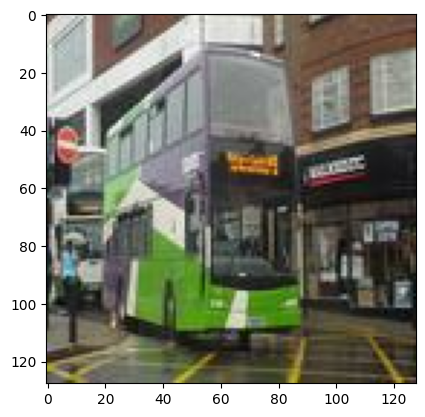

In [33]:
import matplotlib.pyplot as plt
plt.imshow(img3[0])

In [34]:
img_emb=img_encoder.predict(img3)

1/1 [==============================] - 4s 4s/step


In [35]:
def decode_image(embedding):
    #tokenized_input_sentence = caption_vectorization([input_sentence])
    #tokenized_input_sentence = tf.constant(input_sentence)
    #tokenized_input_sentence = tf.reshape(tokenized_input_sentence, (1,))
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vectorization([decoded_sentence])[:, :-1]
        predictions = decoder([ tokenized_target_sentence, embedding ])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [45]:
dots = cap_embeddings @ img_emb.T
dots_relu = np.maximum(0, dots)
sum_dots = np.sum(dots_relu,axis=0)

weighted_emb= np.zeros((1,768))

for i in range(len(cap_embeddings)):
  weighted_emb += dots_relu[i] * cap_embeddings[i]

weighted_emb = weighted_emb / sum_dots

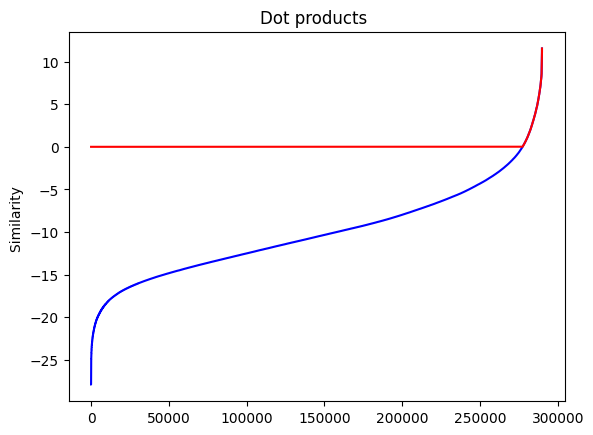

In [46]:
sorted_relu = np.sort(dots_relu, axis=0)
sorted = np.sort(dots, axis=0)
x = list(range(len(sorted)))

plt.plot(x, sorted, label='Dot products ', color='blue')
plt.plot(x, sorted_relu, label='Dot products after a ReLu', color='red')

plt.xlabel('')
plt.ylabel('Similarity ')
plt.title('Dot products ')

plt.show()

In [47]:
expanded = tf.tile(weighted_emb, (20,1))
expanded = tf.reshape(expanded, (1,20,768))
decoded=decode_image(expanded)
#print(sentences[i])
print(decoded)

[start] a double decker bus is parked on the street [end]


In [99]:
sentences[2]

'a double decked bus drives next to some buildings '

In [100]:
print(decode_sequence(sentences[2]))

[start] a double decker bus is parked on the street [end]


# Other images

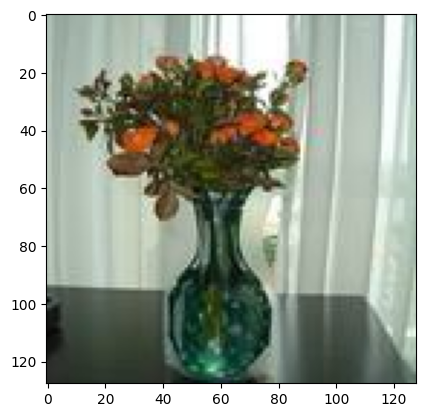

In [48]:
import matplotlib.pyplot as plt
plt.imshow(img1[0])

In [49]:
img_emb=img_encoder.predict(img1)

1/1 [==============================] - 0s 32ms/step


In [50]:
dots = cap_embeddings @ img_emb.T
dots_relu = np.maximum(0, dots)
sum_dots = np.sum(dots_relu,axis=0)

weighted_emb= np.zeros((1,768))

for i in range(len(cap_embeddings)):
  weighted_emb += dots_relu[i] * cap_embeddings[i]

weighted_emb = weighted_emb / sum_dots

In [51]:
expanded = tf.tile(weighted_emb, (20,1))
expanded = tf.reshape(expanded, (1,20,768))
decoded=decode_image(expanded)
#print(sentences[i])
print(decoded)

[start] a vase with flowers in it sitting on a table [end]


In [93]:
sentences[0]

'A white vase containing flowers on desk next to curtains.'

In [92]:
print(decode_sequence(sentences[0]))

[start] a white vase with flowers on a table with flowers in it [end]


# Img 2

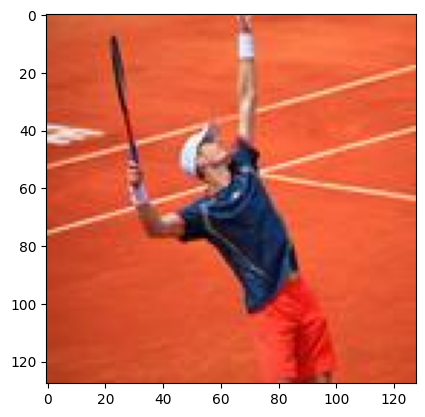

In [88]:
import matplotlib.pyplot as plt
plt.imshow(img2[0])

In [89]:
img_emb=img_encoder.predict(img2)

1/1 [==============================] - 0s 103ms/step


In [90]:
dots = cap_embeddings @ img_emb.T
dots_relu = np.maximum(0, dots)
sum_dots = np.sum(dots_relu,axis=0, dtype=np.double)

weighted_emb= np.zeros((1,768))

for i in range(len(cap_embeddings)):
  weighted_emb += dots_relu[i] * cap_embeddings[i]

weighted_emb = weighted_emb / sum_dots

In [91]:
expanded = tf.tile(weighted_emb, (20,1))
expanded = tf.reshape(expanded, (1,20,768))
decoded=decode_image(expanded)
#print(sentences[i])
print(decoded)

[start] a tennis player holding a tennis racket on a tennis court [end]


In [94]:
sentences[1]

'A man standing on top of a tennis court.'

In [95]:
print(decode_sequence(sentences[1]))

[start] a man standing on a tennis court holding a tennis racket [end]


# img 4


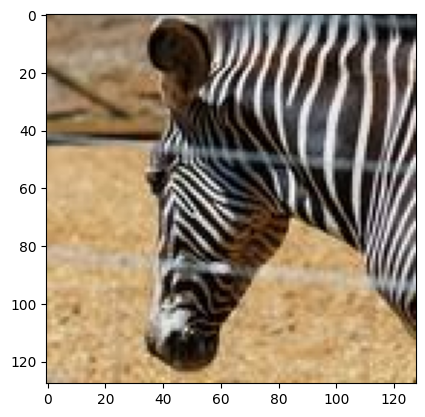

In [56]:
import matplotlib.pyplot as plt
plt.imshow(img4[0])

In [57]:
img_emb=img_encoder.predict(img4)

1/1 [==============================] - 0s 32ms/step


In [58]:
dots = cap_embeddings @ img_emb.T
dots_relu = np.maximum(0, dots)
sum_dots = np.sum(dots_relu,axis=0)

weighted_emb= np.zeros((1,768))

for i in range(len(cap_embeddings)):
  weighted_emb += dots_relu[i] * cap_embeddings[i]

weighted_emb = weighted_emb / sum_dots

In [59]:
expanded = tf.tile(weighted_emb, (20,1))
expanded = tf.reshape(expanded, (1,20,768))
decoded=decode_image(expanded)
#print(sentences[i])
print(decoded)

[start] a zebra standing next to a group of zebra in a grassy area [end]


In [97]:
sentences[3]

'A zebra is standing next to a fence.'

In [98]:
print(decode_sequence(sentences[3]))

[start] a zebra standing next to a fence behind a fence [end]
